# The idea of this notebook
  - demonstrate longitudinal matching of distribution types to arbitrary radio frequency (RF) buckets for a given
      1. RMS bunch length $\sigma_z^{RMS}$
      2. longitudinal emittance $\epsilon_z$ (corresponding to 4x RMS emittance in thermal case)
  - present different available distribution types (and how any new distribution type $\psi(\mathcal{H})$ can easily be implemented):
      1. thermal (Gaussian-like)
      2. $q$-Gaussian (for $q=3/5$, distribution encountered e.g. after LHC longitudinal blow-up)
      3. parabolic
      4. waterbag
  - explain the impact of different moment integrators for non-smooth distribution types (such as e.g. the waterbag)
  - show PyHEADTAIL's flexibility and simplicity for matching more complex RF buckets
  
notebook created by Adrian Oeftiger

# general imports

In [1]:
from __future__ import division, print_function

import numpy as np
np.random.seed(42)

from scipy.constants import m_p, c, e

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

In [2]:
# sets the PyHEADTAIL directory etc.
from settings import *

# PyHEADTAIL imports

In [3]:
from PyHEADTAIL.particles.generators import RFBucketMatcher
from PyHEADTAIL.trackers.rf_bucket import RFBucket

PyHEADTAIL v1.11.5.32




# Settings and Helper Functions

We create a single harmonic RFBucket (parameters are comparable to the CERN Proton Synchrotron injection plateau) to play with. A short bunch length of $4\sigma_\tau = 140$ ns equivalent to a longitudinal emittance of $\epsilon_z=0.764$ eVs will be used for the matching:

In [4]:
rfb = RFBucket(100*2*np.pi, 2.5, m_p, e, [0.027], 0., [8], [24e3], [np.pi])

sigma_z = 140e-9*0.91*c/4. # in [m]
epsn_z = 0.764 # in [eVs]

In [5]:
def plot(stat_dist_class, rfb=rfb, sigma_z=sigma_z, H0=None):
    '''Plot properties of stationary distribution class stat_dist_class
    for the given RF bucket and the bunch length (used for the guessed
    distribution Hamiltonian limit H0).
    Args:
        - stat_dist_class: Stationary Distribution class
          (e.g. rfbucket_matching.ThermalDistribution)
        - rfb: RFBucket instance
        - sigma_z: bunch length to be matched
    '''
    try:
        z_sfp = np.atleast_1d(rfb.z_sfp)
        H_sfp = rfb.hamiltonian(z_sfp, 0, make_convex=True)
        Hmax = max(H_sfp)
        stat_exp = stat_dist_class(
            lambda *args: rfb.hamiltonian(*args, make_convex=True), #always convex Hamiltonian
            Hmax=Hmax,
        )
    except TypeError:
        stat_exp = stat_dist_class
        
    if H0:
        stat_exp.H0 = H0
    else:
        stat_exp.H0 = rfb.guess_H0(sigma_z, from_variable='sigma')

    dpmax = rfb.dp_max(rfb.z_ufp_separatrix)
    zz = np.linspace(rfb.z_left, rfb.z_right, num=1000)
    Z, DP = np.meshgrid(zz, np.linspace(-dpmax*1.1, dpmax*1.1, num=500))

    fig, ax = plt.subplots(2, 2, figsize=(12, 8))

    plt.sca(ax[0, 0])
    plt.title('phase space distribution', fontsize=20)
    plt.contourf(Z, DP, stat_exp.function(Z, DP), 20, cmap=cm.hot_r)
    plt.colorbar().set_label(r'$\psi(z, \delta)$', fontsize=20)
    plt.plot(zz, rfb.separatrix(zz), c='purple', lw=2)
    plt.plot(zz, -rfb.separatrix(zz), c='purple', lw=2)
    plt.xlabel(r'$z$', fontsize=20)
    plt.ylabel(r'$\delta$', fontsize=20)

    plt.sca(ax[0, 1])
    plt.title('Hamiltonian contours', fontsize=20)
    plt.contourf(Z, DP, stat_exp.H(Z, DP), 20, cmap=cm.coolwarm)
    plt.colorbar().set_label(r'$\mathcal{H}(z,\delta)$', fontsize=20)
    plt.plot(zz, rfb.separatrix(zz), c='purple', lw=2)
    plt.plot(zz, -rfb.separatrix(zz), c='purple', lw=2)
    plt.xlabel(r'$z$', fontsize=20)
    plt.ylabel(r'$\delta$', fontsize=20)

    plt.sca(ax[1, 0])
    plt.title('line density', fontsize=20)
    plt.plot(zz, np.sum(stat_exp.function(Z, DP), axis=0), antialiased=False)
    plt.xlabel(r'$z$', fontsize=20)
    plt.ylabel(r'$\lambda(z) = \int\; d\delta \; \psi(z, \delta)$', fontsize=20)

    plt.sca(ax[1, 1])
    plt.title('Hamiltonian distribution', fontsize=20)
    hhs = stat_exp.H(Z, DP).ravel()
    counts = stat_exp.function(Z, DP).ravel()
    perm = np.argsort(hhs)
    plt.plot(hhs[perm], counts[perm])
    plt.xlabel(r'$\mathcal{H}$', fontsize=20)
    plt.ylabel(r'$\psi(\mathcal{H})$', fontsize=20)
    plt.ylim(-0.1, 1.1)
    plt.axvline(0, *plt.ylim(), color='purple', lw=2)
    plt.text(plt.xlim()[0]/15., np.mean(plt.ylim()), 'separatrix', color='purple', rotation=90)

    plt.tight_layout()
    
    return fig

def plot_mp(z, dp, rfb=rfb):
    dpmax = rfb.dp_max(rfb.z_ufp_separatrix)
    zz = np.linspace(rfb.z_left, rfb.z_right, num=1000)
    Z, DP = np.meshgrid(zz, np.linspace(-dpmax*1.1, dpmax*1.1, num=100))
    H = rfb.hamiltonian(Z, DP)
    plt.contour(Z, DP, H, 20, cmap=cm.coolwarm_r)
    # plt.scatter(z, dp, alpha=0.6)
    my_cmap = cm.hot_r
    my_cmap.set_under('w',1)
    plt.hist2d(z, dp, bins=40, cmap=my_cmap)
    plt.plot(zz, rfb.separatrix(zz), c='purple', lw=2)
    plt.plot(zz, -rfb.separatrix(zz), c='purple', lw=2)
    plt.xlim(rfb.z_left, rfb.z_right)
    plt.ylim(-dpmax*1.1, dpmax*1.1)
    plt.colorbar().set_label('# macro-particles', fontsize=20)
    plt.xlabel(r'$z$', fontsize=20)
    plt.ylabel(r'$\delta$', fontsize=20)
    plt.title('macro-particle generation', fontsize=20)
    return zz, Z, DP

# Let's go

## A. Implemented Distribution Types in PyHEADTAIL

Any distribution $\psi=\psi(\mathcal{H})$ depending on the Hamiltonian of the entire system is stationary or "matched". The RF bucket's shape determines the Hamiltonian landscape $\mathcal{H}$, which is separate from the distribution function $\psi$ determining how many particles are sitting at certain Hamiltonian values. A certain (e.g. single harmonic) RF bucket can thus be filled with different distribution types. The ones implemented in PyHEADTAIL are presented in the following.

### 1. Thermal (Gaussian-like) Distribution 

The thermal Boltzmann distribution $\psi(\mathcal{H}) \propto \exp(-\mathcal{H}/\mathcal{H}_0)$ is an often used longitudinal distribution type and is the default for PyHEADTAIL's `RFBucket` matching. In a linear "bucket" (i.e. in the quadratic harmonic oscillator Hamiltonian case) the thermal distribution yields a bi-Gaussian macro-particle distribution.

In the following plots you can see the previously defined single-harmonic RF bucket with
- **top left**: the analytical $(z, \delta=\frac{p-p_0}{p_0}|_{RMS})$ phase space distribution function for a bunch length of $140$ ns within the purple separatrices: the darker the distribution colour, the denser the probability distribution function;
- **top right**: the Hamiltonian geometry and the separatrix value at $\mathcal{H}=0$ according to PyHEADTAIL's convention -- note that PyHEADTAIL inverts the RF Hamiltonian to have positive values inside the separatrix and negative values outside. The corresponding internal coordinate transformation follows $\mathcal{H}\mapsto \mathcal{H}_{separatrix} - \mathcal{H}$ (simplifying the particle generation);
- **bottom left**: the spatial projection of the phase space distribution yielding the line density (in arbitrary units);
- **bottom right**: the distribution function in terms of the Hamiltonian in PyHEADTAIL's convention. Note that the distribution function vanishes outside the separatrix, $\psi(\mathcal{H}\leq 0) \equiv 0$.

For the `ThermalDistribution`, the distribution function is non-zero within the entire RF bucket area and particles can become generated everywhere but with an exponentially increasing probability in the centre of the single harmonic bucket.

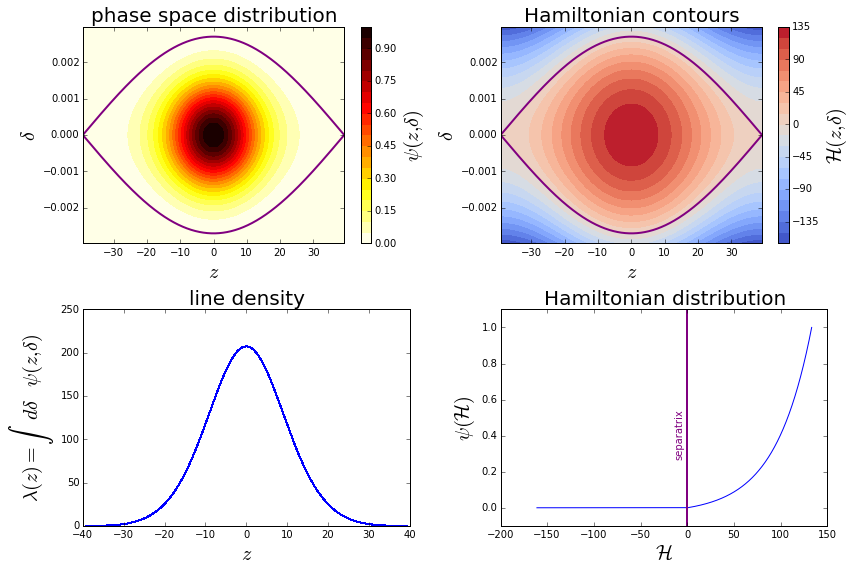

In [6]:
from PyHEADTAIL.particles.rfbucket_matching import ThermalDistribution

plot(ThermalDistribution);

We can now use the `RFBucketMatcher` with the `sigma_z` keyword argument to 
1. semi-analytically compute the $\mathcal{H}_0$ value of the `ThermalDistribution` which provides the chosen bunch length of $\sigma_z^{RMS} = 140$ ns, and
2. generate $10^5$ randomly distributed macro-particle locations in $(z,\delta)$ phase space, which follow the thermal distribution function:

In [7]:
rfb_matcher = RFBucketMatcher(rfb, ThermalDistribution, sigma_z=sigma_z)
rfb_matcher_thermal = rfb_matcher

z, dp, _, _ = rfb_matcher.generate(int(1e5))

*** Maximum RMS bunch length 12.3783736052m.
... distance to target bunch length: -9.4536e+00
... distance to target bunch length: 2.4885e+00
... distance to target bunch length: 2.2745e+00
... distance to target bunch length: 3.7583e-01
... distance to target bunch length: -7.3492e-01
... distance to target bunch length: 5.6593e-02
... distance to target bunch length: -1.0654e-03
... distance to target bunch length: 1.3870e-05
... distance to target bunch length: -4.5420e-05
--> Bunch length: 9.5484036574
--> Emittance: 0.76406973485


In the same way, we can specify a target longitudinal emittance to which the `RFBucketMatcher` should converge by providing the `epsn_z` keyword argument instead of `sigma_z`:

In [8]:
rfb_matcher = RFBucketMatcher(rfb, ThermalDistribution, epsn_z=epsn_z)

z, dp, _, _ = rfb_matcher.generate(int(1e5))

*** Maximum RMS emittance 1.20450633967eV s.
... distance to target emittance: -7.56e-01
... distance to target emittance: 2.95e-01
... distance to target emittance: 2.35e-01
... distance to target emittance: 2.21e-02
... distance to target emittance: -1.53e-02
... distance to target emittance: 6.63e-04
... distance to target emittance: 1.89e-05
... distance to target emittance: -8.40e-10
... distance to target emittance: 4.22e-06
--> Emittance: 0.76399999916
--> Bunch length:9.54790100649


The Monte-Carlo generated random numbers for the phase space location of the macro-particles indeed show a (slightly noisy) thermal distribution:

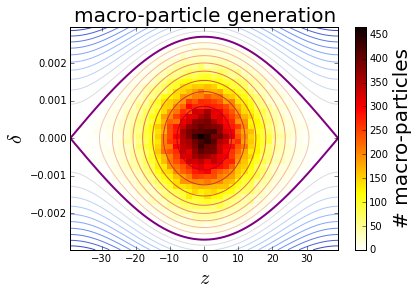

In [9]:
zz, Z, DP = plot_mp(z, dp)

If you specify a too large target value for either `sigma_z` or `epsn_z`, the `RFBucketMatcher` will discard your choice and automatically choose the largest possible value:

In [10]:
rfb_matcher = RFBucketMatcher(rfb, ThermalDistribution, sigma_z=float(np.diff(rfb.interval)))

z, dp, _, _ = rfb_matcher.generate(int(1e5))

*** PyHEADTAIL WARNING! Given RMS bunch length does not fit into bucket. Using (maximum) full bucket RMS bunch length 12.2545898701m instead.
*** Maximum RMS bunch length 12.3783736062m.
... distance to target bunch length: -1.2132e+01
... distance to target bunch length: -2.1772e-01
*** PyHEADTAIL WARNING! Failed to converge with Brent method, continuing with Newton-Raphson method.
... distance to target bunch length: -1.4047e+00
... distance to target bunch length: -1.4043e+00
... distance to target bunch length: -5.9178e-01
... distance to target bunch length: -3.4994e-01
... distance to target bunch length: -1.7077e-01
... distance to target bunch length: -8.0510e-02
... distance to target bunch length: -3.1001e-02
... distance to target bunch length: -8.6550e-03
... distance to target bunch length: -1.2846e-03
... distance to target bunch length: -6.3163e-05
... distance to target bunch length: -4.8726e-07
... distance to target bunch length: -1.8642e-10
--> Bunch length: 12.25458

/afs/cern.ch/user/o/oeftiger/anaconda/lib/python2.7/site-packages/scipy/integrate/quadpack.py:352: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


It is interesting to observe the influence of the RF bucket non-linearities onto the matched distribution here. The stationary `ThermalDistribution` slightly differs from a Gaussian: the increasing non-linearities towards the separatrix suppress the probability distribution function compared to an exact Gaussian around the tails. Correspondingly, the profile widens overall to reach the specified RMS bunch length. Comparing to an exact Gaussian profile of the same $\sigma_z^{RMS}$, this effect renders the matched stationary thermal distribution wider around the core and suppresses the tails (which reach zero at the unstable fix point of the RF bucket anyway while the exact Gaussian would reach infinity):

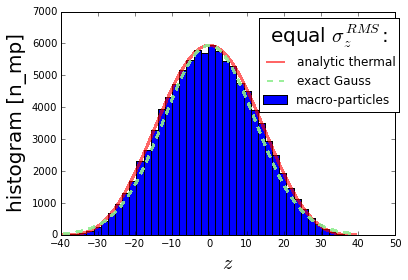

In [11]:
analytical_res = np.sum(rfb_matcher.psi_object.function(Z, DP), axis=0)
n, _, _ = plt.hist(z, bins=40, label='macro-particles')
plt.plot(zz, analytical_res * n.max() / analytical_res.max(), 
         antialiased=False, color='red', alpha=0.6, lw=2, 
         label='analytic thermal')
sz = rfb_matcher._compute_sigma(rfb, rfb_matcher.psi)
plt.plot(zz, np.exp(-zz**2/(2*sz**2)) * n.max(), 
         antialiased=False, color='lightgreen', alpha=0.9, lw=2, ls='--',
         label='exact Gauss')
plt.xlim(-40, 50)
plt.ylim(0, 7000)
legend = plt.legend(bbox_to_anchor=(1.03, 1), title=r'equal $\sigma_z^{RMS}$:');
plt.setp(legend.get_title(), fontsize=20)
plt.xlabel(r'$z$', fontsize=20)
plt.ylabel('histogram [n_mp]', fontsize=20);

### 2. $q$-Gaussian Distribution

The `QGaussianDistribution` for $q=3/5$ follows $\psi(\mathcal{H}) \propto (1 - \mathcal{H}/\mathcal{H}_0)^2$ and resembles the profiles measured after the longitudinal blow-up in the LHC. The line density is wider around the core and features less far-reaching tails compared to the `ThermalDistribution`.

The distribution function reaches zero already within the bucket area at finite distance to the separatrix, as the lower right plot shows:

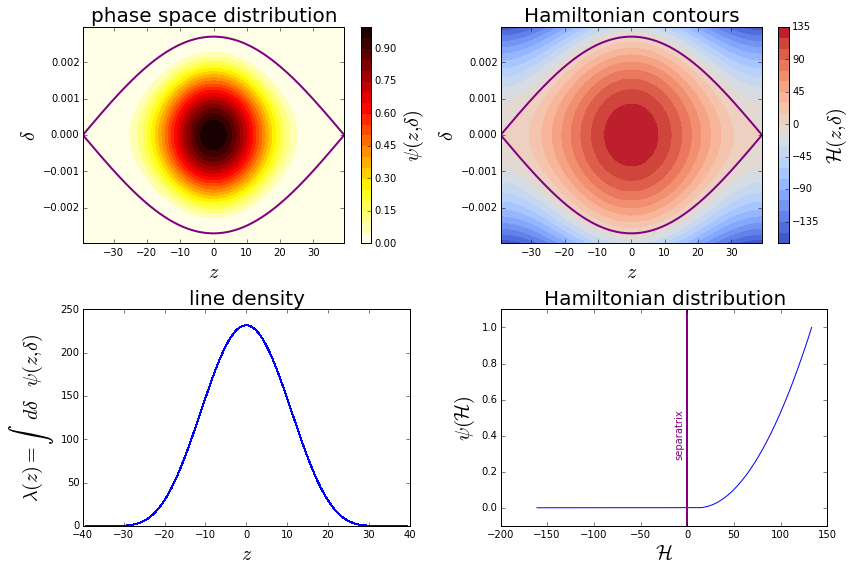

In [12]:
from PyHEADTAIL.particles.rfbucket_matching import QGaussianDistribution

plot(QGaussianDistribution, H0=122.135628109);

The iterative matching runs slower for the `QGaussianDistribution` when the default moment integrator is used: the "quad" integrator from `PyHEADTAIL.cobra_functions.pdf_integrators_2d` is based on the iteratively refining `scipy.integrate.dblquad` function allowing for very accurate 2D integrals. The drawback of this integrator is bad convergency for non-smooth integrands, which is the case for our clipped distribution function (the derivative $\partial\psi/\partial\mathcal{H}$ is discontinuous). 

We can speed up the semi-analytic $\mathcal{H}_0$ computation by using the non-refining "cumtrapz" integrator (which is less accurate than "quad" but still very good and, most of all, insensitive to discontinuities). **This can be achieved by changing `RFBucketMatcher.integrationmethod` from "quad" to "cumtrapz"**:

In [13]:
rfb_matcher = RFBucketMatcher(rfb, QGaussianDistribution, sigma_z=sigma_z)
rfb_matcher_qGauss = rfb_matcher

rfb_matcher.integrationmethod = 'cumtrapz'

z, dp, _, _ = rfb_matcher.generate(int(1e5))
z_s, dp_s = z, dp

*** Maximum RMS bunch length 17.0887097664m.
... distance to target bunch length: -9.5484e+00
... distance to target bunch length: 6.3818e+00
... distance to target bunch length: 2.9760e+00
... distance to target bunch length: -3.5767e+00
... distance to target bunch length: -4.0670e-01
... distance to target bunch length: -3.1406e-02
... distance to target bunch length: 5.4500e-04
... distance to target bunch length: -1.2376e-06
... distance to target bunch length: 1.3058e-04
--> Bunch length: 9.54838854972
--> Emittance: 0.779642492249


Again, obviously we can also match for the longitudinal emittance instead of the bunch length:

In [14]:
rfb_matcher = RFBucketMatcher(rfb, QGaussianDistribution, epsn_z=epsn_z)

rfb_matcher.integrationmethod = 'cumtrapz'

z, dp, _, _ = rfb_matcher.generate(int(1e5))

*** Maximum RMS emittance 1.95957084113eV s.
... distance to target emittance: -7.62e-01
... distance to target emittance: 3.91e-01
... distance to target emittance: -4.75e-02
... distance to target emittance: -1.41e-03
... distance to target emittance: 1.44e-05
... distance to target emittance: -6.12e-09
--> Emittance: 0.763999993877
--> Bunch length:9.43572677714


Due to the different distribution type, the relation between the matched RMS bunch length and the longitudinal emittance changes for non-linear RF buckets, which is why the two parameters vary between the above two matching approaches.

The attentive reader may have noticed that we specified a `H0` value for the above analytical plots. To reach the same bunch length as the `ThermalDistribution`, the corresponding `H0` value is quite different (a detail of minor importance):

In [15]:
print ("thermal H0:", rfb_matcher_thermal.psi_object.H0)
print ("q-Gaussian H0:", rfb_matcher_qGauss.psi_object.H0)
print ("for the same bunch length", 
       rfb_matcher_thermal._compute_sigma(
           rfb, rfb_matcher_thermal.psi_object), 
       "(thermal) vs. ",
       rfb_matcher_qGauss._compute_sigma(
           rfb, rfb_matcher_qGauss.psi_object), 
       "(q-Gaussian)!",
       )

thermal H0: 36.1934174669
q-Gaussian H0: 122.135605175
for the same bunch length 9.5484036574 (thermal) vs.  9.54838854972 (q-Gaussian)!


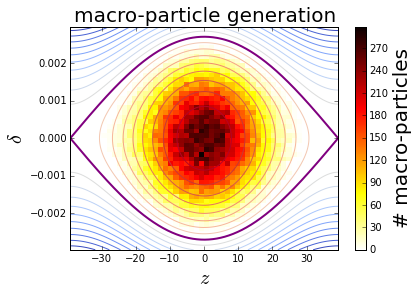

In [16]:
zz, Z, DP = plot_mp(z, dp)

Comparing to the `ThermalDistribution` matched to the same bunch length $\sigma_z^{RMS}$ from above, the generated macro-particles following the `QGaussianDistribution` form a line density with a clearly wider core while the tails vanish to zero earlier:

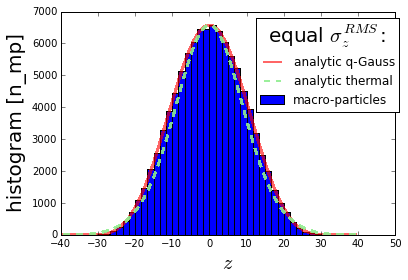

In [17]:
analytical_res = np.sum(rfb_matcher_qGauss.psi_object.function(Z, DP), axis=0)
analytical_res_thermal = np.sum(rfb_matcher_thermal.psi_object.function(Z, DP), axis=0)
n, _, _ = plt.hist(z_s, bins=36, label='macro-particles')
plt.plot(zz, analytical_res * n.max() / analytical_res.max(), 
         antialiased=False, color='red', alpha=0.6, lw=2, 
         label='analytic q-Gauss')
plt.plot(zz, analytical_res_thermal * n.max() / analytical_res_thermal.max(), 
         antialiased=False, color='lightgreen', alpha=0.9, lw=2, ls='--',
         label='analytic thermal')
plt.xlim(-40, 50)
legend = plt.legend(bbox_to_anchor=(1.03, 1), title=r'equal $\sigma_z^{RMS}$:');
plt.setp(legend.get_title(), fontsize=20)
plt.xlabel(r'$z$', fontsize=20)
plt.ylabel('histogram [n_mp]', fontsize=20)

### 3. Parabolic Bunch Shape

The `ParabolicDistribution` implements the probability distribution function $\psi(\mathcal{H})\propto \sqrt{1 - \mathcal{H}/\mathcal{H}_0}$. The spatial profile corresponds to a parabolic shape in the case of a "linear" RF bucket (the quadratic harmonic oscillator Hamiltonian). For a truly non-linear bucket, the matched parabolic distribution becomes a bit wider compensating for the non-linearities of the bucket, as one can see in the lower left plot:

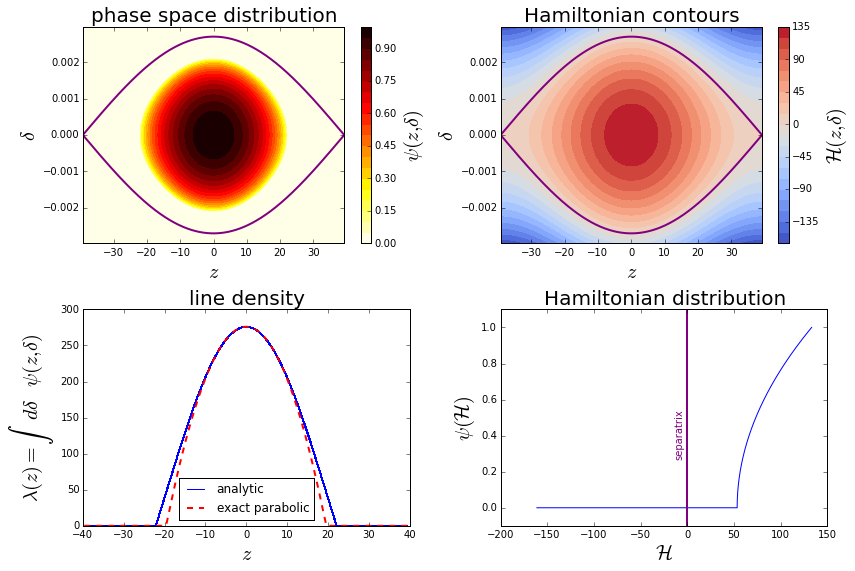

In [18]:
from PyHEADTAIL.particles.rfbucket_matching import ParabolicDistribution

fig = plot(ParabolicDistribution, H0=79.8);

plt.sca(fig.axes[2])
zz = np.linspace(*rfb.interval, num=100)
plt.plot(zz, (276 - 0.72*zz**2).clip(min=0), color='red', lw=2, ls='--')
plt.legend(['analytic', 'exact parabolic'], loc=8);

Note the sharp discontinuity in the lower right plot above at the Hamiltonian value where the probability distribution function $\psi(\mathcal{H})$ is clipped to zero. Therefore, for the RF bucket matching, the "cumtrapz" integrator comes in handy again (similarly to the above `QGaussianDistribution` matching, otherwise the default "quad" integrator literally takes ages):

In [19]:
rfb_matcher = RFBucketMatcher(rfb, ParabolicDistribution, sigma_z=sigma_z)

rfb_matcher.integrationmethod = 'cumtrapz'

z, dp, _, _ = rfb_matcher.generate(int(1e5))

*** Maximum RMS bunch length 17.0908549955m.
... distance to target bunch length: -9.5484e+00
... distance to target bunch length: 7.2559e+00
... distance to target bunch length: 5.9701e+00
... distance to target bunch length: -3.0862e+00
... distance to target bunch length: -5.2158e-01
... distance to target bunch length: 1.0521e-02
... distance to target bunch length: -3.3879e-04
... distance to target bunch length: -3.0885e-06
... distance to target bunch length: 1.1633e-04
--> Bunch length: 9.54838669878
--> Emittance: 0.794758715571


The phase space distribution of the macro-particles already looks quite different from the previous cases:

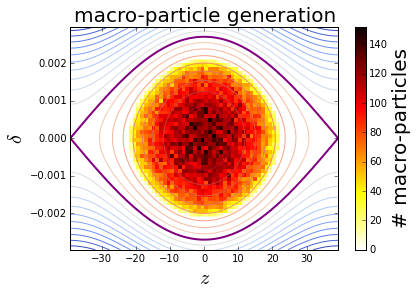

In [20]:
zz, Z, DP = plot_mp(z, dp)

... and the line density in terms of the spatial macro-particles histogram looks beautifully parabolic-like:

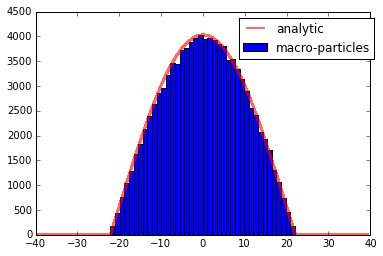

In [21]:
analytical_res = np.sum(rfb_matcher.psi_object.function(Z, DP), axis=0)
n, _, _ = plt.hist(z, bins=40, label='macro-particles')
plt.plot(zz, analytical_res * n.max() / analytical_res.max(), 
         antialiased=False, color='red', alpha=0.6, lw=2, 
         label='analytic')
plt.legend(bbox_to_anchor=(1.03, 1));

### 4. Waterbag

Last but not least, the `WaterbagDistribution` is a useful distribution when benchmark with analytical results. The distribution function reads $\psi(\mathcal{H})\propto \Theta(\mathcal{H}_0 - \mathcal{H})$ with $\Theta$ the Heaviside step function.

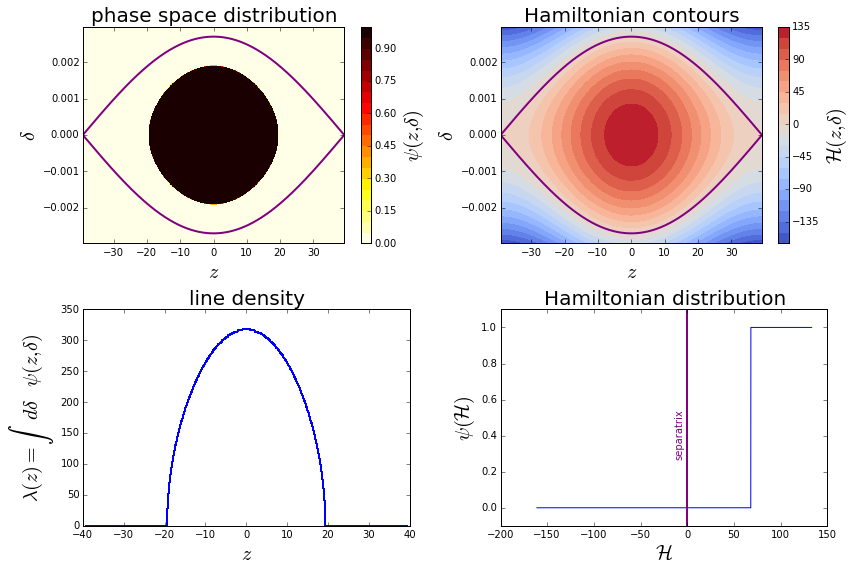

In [22]:
from PyHEADTAIL.particles.rfbucket_matching import WaterbagDistribution

plot(WaterbagDistribution, H0=65.2);

The shape of the `WaterbagDistribution` becomes particularly beautiful when being matched to a large bunch length, such that the edge of the non-zero distribution function patch assumes the shape of the RF bucket separatrix. Observe the deforming along the Hamiltonian contours close to the unstable fix points:

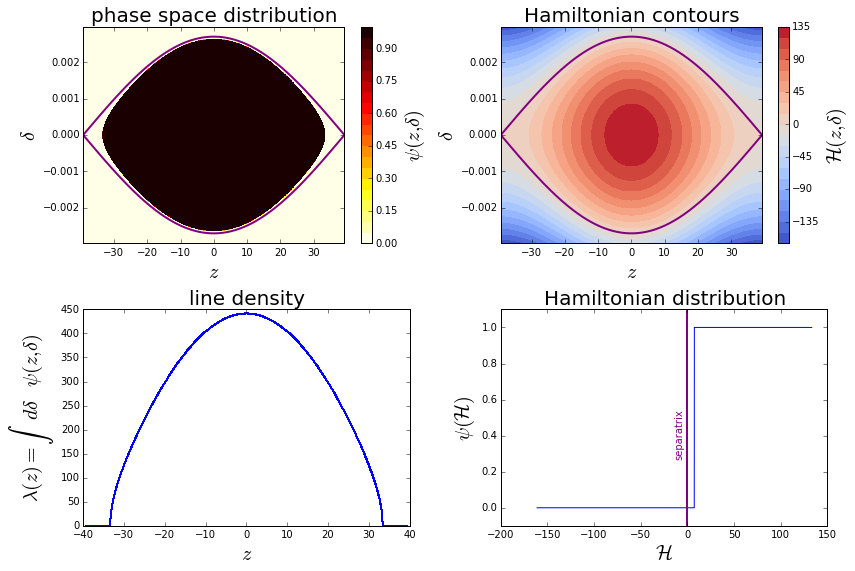

In [23]:
plot(WaterbagDistribution, sigma_z=1.8*sigma_z);

The waterbag distribution function is discontinuous at $\mathcal{H}_0$ making the use of the "quad" integrator impossible. Here, changing to the "cumtrapz" integrator is a necessary ingredient to successfully compute the distribution momenta for the `RFBucketMatcher`:

In [24]:
rfb_matcher = RFBucketMatcher(rfb, WaterbagDistribution, sigma_z=sigma_z)

rfb_matcher.integrationmethod = 'cumtrapz'

z, dp, _, _ = rfb_matcher.generate(int(1e5))

*** Maximum RMS bunch length 17.0915700225m.
... distance to target bunch length: -9.5484e+00
... distance to target bunch length: 7.5432e+00
... distance to target bunch length: 7.5432e+00
... distance to target bunch length: -2.4127e+00
... distance to target bunch length: -4.1511e-01
... distance to target bunch length: 1.0734e-02
... distance to target bunch length: -2.9878e-03
... distance to target bunch length: 5.3043e-04
... distance to target bunch length: 1.4292e-04
... distance to target bunch length: 1.4292e-04
... distance to target bunch length: -1.6975e-03
... distance to target bunch length: 1.4292e-04
... distance to target bunch length: 1.8850e-05
... distance to target bunch length: -1.1603e-03
--> Bunch length: 9.54840863759
--> Emittance: 0.801855563296


Indeed, the generated macro-particles form a uniform patch in longitudinal phase space (up to statistical noise):

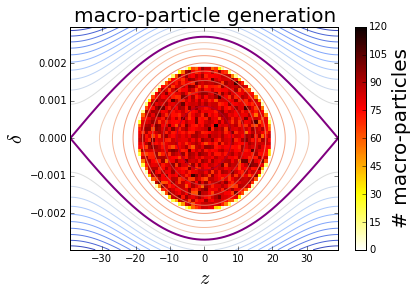

In [25]:
plot_mp(z, dp);

## B. More Complex RF Buckets? Let's go!

So far we have always matched the different distribution types to a single harmonic bucket. In principle, we simply need to provide a different RFBucket instance to match the same distribution type to a different RF bucket. Let's try something more fancy in an accelerating double harmonic bucket:

In [26]:
rfb2 = RFBucket(100*2*np.pi, 2.5, m_p, e, [0.027], 1e-24, [8, 16], [24e3, 20e3], [np.pi, 0])

### 1. Thermal Distribution in Accelerating Double Harmonic Bucket

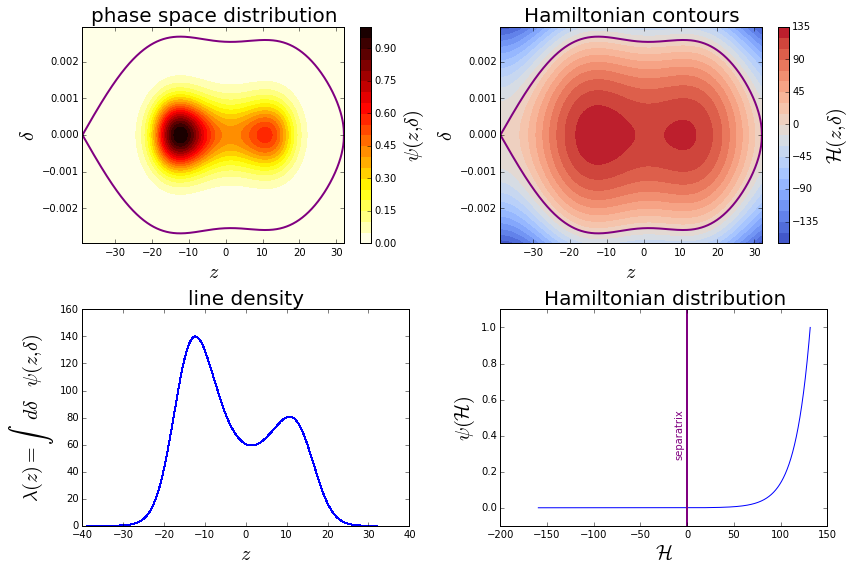

In [27]:
plot(ThermalDistribution, rfb=rfb2, H0=16);

Compared to the single harmonic case, we just have to use the new RFBucket instance `rfb2` and plug it into the RFBucketMatcher, which will do the rest:

In [28]:
rfb_matcher = RFBucketMatcher(rfb2, ThermalDistribution, sigma_z=1.2*sigma_z)

z, dp, _, _ = rfb_matcher.generate(int(1e5))

*** Maximum RMS bunch length 14.6639459805m.
... distance to target bunch length: -1.0352e+01
... distance to target bunch length: 3.1500e+00
... distance to target bunch length: 3.1103e+00
... distance to target bunch length: 2.8129e+00
... distance to target bunch length: 1.5749e+00
... distance to target bunch length: -9.9839e-01
... distance to target bunch length: 2.3178e-01
... distance to target bunch length: 2.4292e-02
... distance to target bunch length: 7.9674e-05
... distance to target bunch length: 4.1080e-08
... distance to target bunch length: -3.9089e-05
--> Bunch length: 11.4580677858
--> Emittance: 0.683677968034


Compare the macro-particle distribution below to the analytic distribution function above:

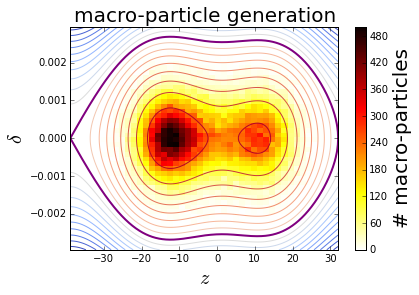

In [29]:
plot_mp(z, dp, rfb=rfb2);

### 2. $q$-Gaussian Distribution in Accelerating Double Harmonic Bucket

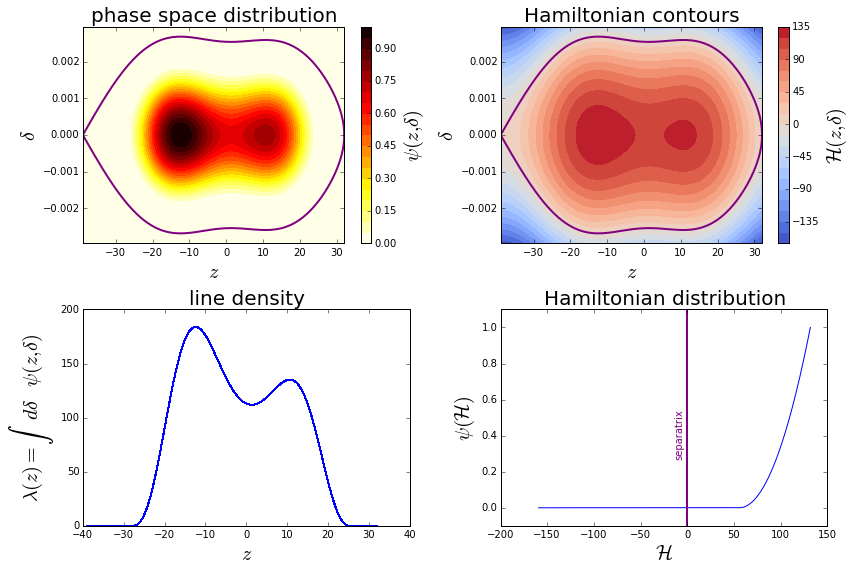

In [30]:
plot(QGaussianDistribution, rfb=rfb2, H0=76);

We can also match with respect to the longitudinal emittance again: 

In [31]:
rfb_matcher = RFBucketMatcher(rfb2, QGaussianDistribution, epsn_z=epsn_z)

rfb_matcher.integrationmethod = 'cumtrapz'

z, dp, _, _ = rfb_matcher.generate(int(1e5))

*** Maximum RMS emittance 2.15088329569eV s.
... distance to target emittance: -7.61e-01
... distance to target emittance: 1.02e+00
... distance to target emittance: 3.96e-01
... distance to target emittance: 8.02e-02
... distance to target emittance: 5.16e-03
... distance to target emittance: 7.46e-05
... distance to target emittance: 7.15e-08
... distance to target emittance: -5.52e-06
--> Emittance: 0.764000071548
--> Bunch length:11.8113502938


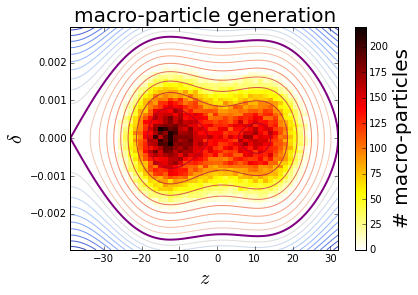

In [32]:
plot_mp(z, dp, rfb=rfb2);

### 3. Parabolic Distribution in Accelerating Double Harmonic Bucket

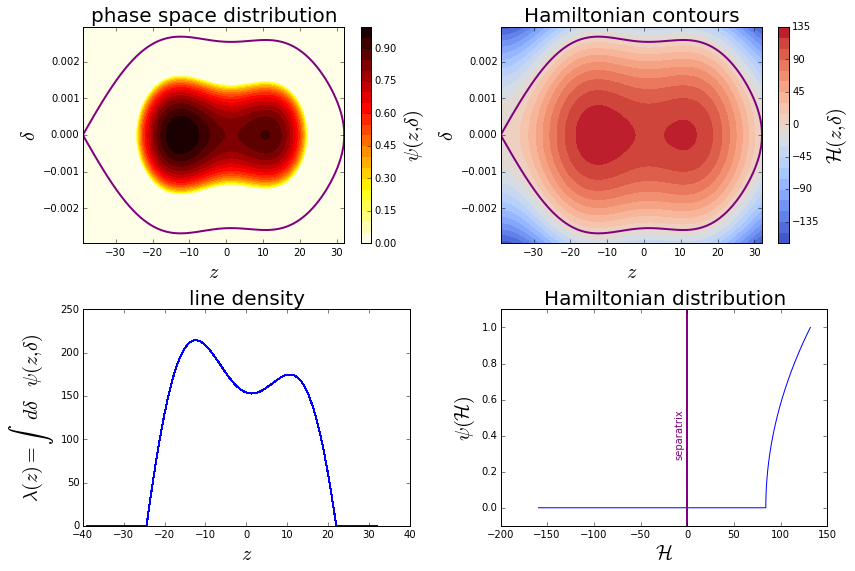

In [33]:
plot(ParabolicDistribution, rfb=rfb2, H0=47.7);

In [34]:
rfb_matcher = RFBucketMatcher(rfb2, ParabolicDistribution, epsn_z=epsn_z)

rfb_matcher.integrationmethod = 'cumtrapz'

z, dp, _, _ = rfb_matcher.generate(int(1e5))

*** Maximum RMS emittance 2.15103961677eV s.
... distance to target emittance: -7.59e-01
... distance to target emittance: 1.29e+00
... distance to target emittance: 7.67e-01
... distance to target emittance: 1.15e-01
... distance to target emittance: 2.49e-02
... distance to target emittance: 3.20e-04
... distance to target emittance: -2.32e-07
... distance to target emittance: 5.74e-06
--> Emittance: 0.763999767887
--> Bunch length:11.8141131886


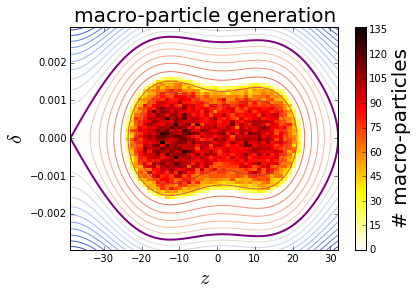

In [35]:
plot_mp(z, dp, rfb=rfb2);

### 4. Waterbag Distribution in Accelerating Double Harmonic Bucket

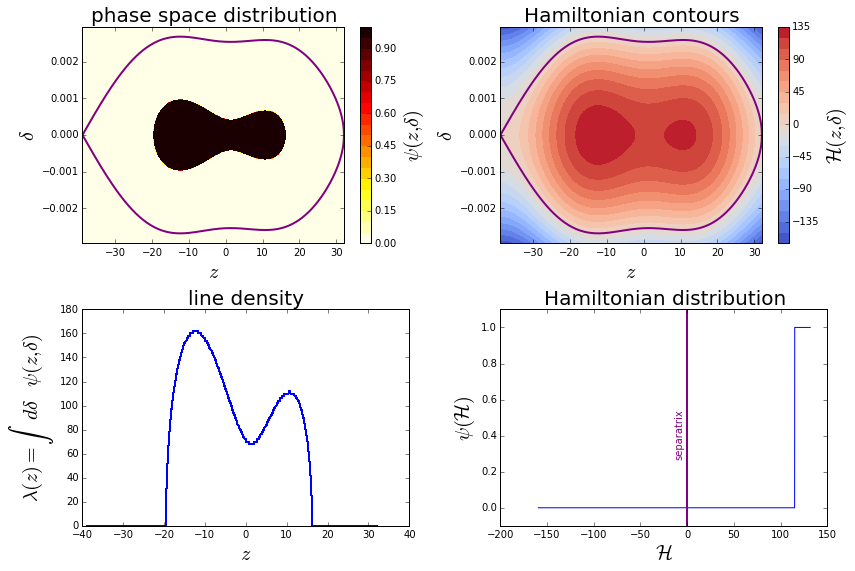

In [36]:
plot(WaterbagDistribution, rfb=rfb2, H0=16.7);

In [37]:
rfb_matcher = RFBucketMatcher(rfb2, WaterbagDistribution, epsn_z=0.5*epsn_z)

rfb_matcher.integrationmethod = 'cumtrapz'

z, dp, _, _ = rfb_matcher.generate(int(1e5))

*** Maximum RMS emittance 2.15109172443eV s.
... distance to target emittance: -3.79e-01
... distance to target emittance: 1.77e+00
... distance to target emittance: 6.32e-01
... distance to target emittance: 7.37e-02
... distance to target emittance: 1.07e-02
... distance to target emittance: 2.10e-04
... distance to target emittance: 1.34e-04
... distance to target emittance: -1.53e-04
... distance to target emittance: 4.76e-05
... distance to target emittance: -4.07e-06
... distance to target emittance: 4.84e-06
--> Emittance: 0.381995932897
--> Bunch length:10.150766877


Aaaand voilà, the beautifully peanut-shaped waterbag distribution matched to the Hamiltonian topology! Note how the edge of the waterbag patch resembles the Hamiltonian contours:

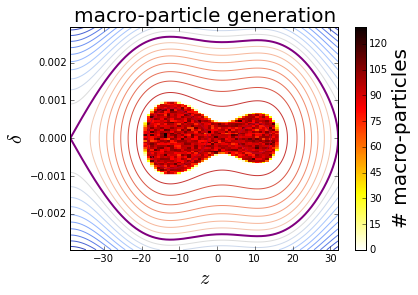

In [38]:
plot_mp(z, dp, rfb=rfb2);

# ... do you agree that this is fun? :-)